# Imports

In [1]:
import sys

sys.path.append("..")
import pickle as pkl
from dataclasses import asdict, is_dataclass

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from dacite import from_dict
from ipywidgets import interact

from calibration.benchmark.benchmark_result import (
    BenchmarkResult,
    calc_error,
    results_into_df,
)
from calibration.feature_detector.visualization import show_boards, show_corners
from calibration.projector.board import gen_checkerboard_grid
from calibration.projector.camera import Camera

# pio.renderers.default = "svg"
from calibration.projector.projector import Projector
from calibration.solver.optimization.solve import solve as solve_optimization
from calibration.solver.scaramuzza.solve import solve as solve_scaramuzza

# from calibration.solver.solve import solve

%load_ext autoreload
%autoreload 2

In [17]:
with open("../babelcalib_results_None.pkl", "rb") as f:
    results = pkl.load(f)

In [3]:
df = results_into_df(results)

# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 27 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   input.ds_name                                 792 non-null    object 
 1   input.subds_name                              792 non-null    object 
 2   input.name                                    792 non-null    object 
 3   input.width                                   792 non-null    int64  
 4   input.height                                  792 non-null    int64  
 5   input.num_corners                             792 non-null    int64  
 6   input.encoding                                792 non-null    object 
 7   input.corners                                 792 non-null    object 
 8   input.image                                   792 non-null    object 
 9   features.board                                792 non-null    obj

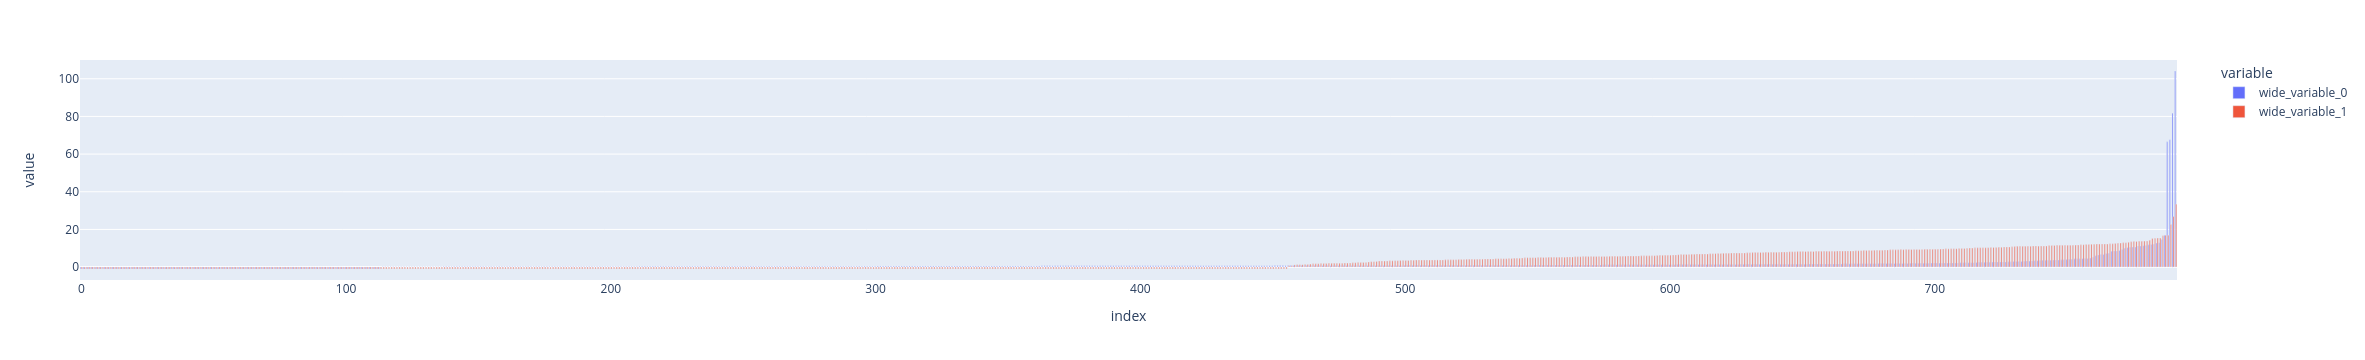

In [18]:
resultsO = sorted(
    [r for r in results if r.errors["Optimization"] is not None],
    key=lambda r: r.errors["Optimization"],
)
resultsS = sorted(
    [r for r in results if r.errors["Scaramuzza"] is not None],
    key=lambda r: r.errors["Scaramuzza"],
)

# df_ = df[~df["error"].isna()].sort_values("error")

px.bar(
    y=[
        sorted([r.errors["Optimization"] for r in resultsO]),
        sorted([r.errors["Scaramuzza"] for r in resultsS]),
    ],
    barmode="group",
)

In [4]:
results_ = sorted(results, key=lambda r: r.errors["Optimization"])

In [14]:
@interact
def f(i=(0, len(results)), solver=["Optimization", "Scaramuzza", "Live optimize"]):
    r = results_[i]
    w, h = r.input.image.size

    print(f"{i}, error_Optim={r.errors['Optimization']}")

    match solver:
        case "Optimization" | "Scaramuzza":
            try:
                proj = r.predictions[solver]
                error = r.errors[solver]
            except KeyError:
                print(f"Cannot get {solver} from {r.predictions.keys()}")
        case "Live optimize":
            proj, hist = solve_optimization(
                r.features.corners,
                r.features.board,
                Camera(resolution=np.array(r.input.image.size)),
            )
            ret = proj

            px.line(hist).show()
            error = calc_error(proj, r.features)
        case _:
            raise NotImplementedError

    print(f"Error {solver}: {error}")

    assert r.features is not None

    # fig1 = show_boards(
    #     r.input.image, r.features.corners, r.features.board
    # ).update_layout(height=h, width=w)
    # display(fig1)

    try:
        max_point_img_space = np.r_[proj.camera.resolution, 1]
        max_point = np.linalg.inv(proj.camera.intrinsic_matrix) @ max_point_img_space
        max_r = float(np.linalg.norm(max_point[:2]))
        corners_ = proj.project(r.features.board, max_r * 10)
        # corners_ = r.prediction.project(r.features.board, 100)
            # px.scatter(
            #     corners_,
            #     x=0,
            #     y=1,
            #     title="Projected corners",
            #     range_x=[0, w],
            #     range_y=[0, h],
            #     # height=h,
            #     # width=w,
            # ).update_yaxes(autorange="reversed")
                # px.scatter(
                #     r.features.corners,
                #     x=0,
                #     y=1,
                #     title="Original corners",
                #     color=range(r.features.corners.shape[0]),
                #     range_x=[0, w],
                #     range_y=[0, h],
                #     # height=h,
                #     # width=w,
                # ).update_yaxes(autorange="reversed")
        show_boards(r.input.image, corners_, r.features.board).update_layout(
                    height=h, width=w, title="Projected corners"
        ).show('svg')
    except ValueError:
        print("Cannot project")
    px.scatter(
            r.features.board,
            x=0,
            y=1,
            color=range(r.features.board.shape[0]),
            title="Original board",
            # height=h,
            # width=w,
    ).show('svg')
    board_ = proj.backproject(r.features.corners)
    px.scatter(
            board_,
            x=0,
            y=1,
            title="Backprojected board",
            # height=h,
            # width=w,
        ).show('svg')
    # display(
    #     # px.scatter(
    #     #     r.features.corners,
    #     #     x=0,
    #     #     y=1,
    #     #     title="Original corners",
    #     #     color=range(r.features.corners.shape[0]),
    #     #     range_x=[0, w],
    #     #     range_y=[0, h],
    #     #     # height=h,
    #     #     # width=w,
    #     # ).update_yaxes(autorange="reversed")
    #     show_boards(r.input.image, r.features.corners, r.features.board).update_layout(
    #         height=h, width=w, title="Original corners"
    #     )
    # )

    print(proj.R)
    print(proj.t)
    print(proj.lambdas)

interactive(children=(IntSlider(value=396, description='i', max=792), Dropdown(description='solver', options=(…

In [ ]:
i = 85
r = results_[i]

# key = "OV/cube/ov00", "train", "ov00/0031.pgm"
# i, r = next(
#     (i, r)
#     for i, r in enumerate(results)
#     if (r.input.ds_name, r.input.subds_name, r.input.name) == key
# )

solver = "Live optimize"

w, h = r.input.image.size

print(f"{i}, error_Optim={r.errors['Optimization']}")

match solver:
    case "Optimization" | "Scaramuzza":
        try:
            proj = r.predictions[solver]
            error = r.errors[solver]
        except KeyError:
            print(f"Cannot get {solver} from {r.predictions.keys()}")
    case "Live optimize":
        proj = solve_optimization(
            r.features.corners,
            r.features.board,
            Camera(resolution=r.input.image.size),
        )
        error = calc_error(proj, r.features)
    case _:
        raise NotImplementedError

assert r.features is not None

# fig1 = show_boards(r.input.image, r.features.corners, r.features.board).update_layout(
#     height=h, width=w
# )
# display(fig1)
display(
    px.scatter(
        r.features.board,
        x=0,
        y=1,
        color=range(r.features.board.shape[0]),
        title="Original board",
        # height=h,
        # width=w,
    )
)
# display(
#     px.scatter(
#         r.features.corners,
#         x=0,
#         y=1,
#         title="Original corners",
#         color=range(r.features.corners.shape[0]),
#         range_x=[0, w],
#         range_y=[0, h],
#         # height=h,
#         # width=w,
#     ).update_yaxes(autorange="reversed")
# )

board_ = proj.backproject(r.features.corners)
display(
    px.scatter(
        board_,
        x=0,
        y=1,
        title="Backprojected board",
        # height=h,
        # width=w,
    )
)
try:
    max_point_img_space = np.r_[proj.camera.resolution, 1]
    max_point = np.linalg.inv(proj.camera.intrinsic_matrix) @ max_point_img_space
    max_r = float(np.linalg.norm(max_point[:2]))
    corners_ = proj.project(r.features.board, max_r * 10)
    # corners_ = r.prediction.project(r.features.board, 100)
    # display(
    #     px.scatter(
    #         corners_,
    #         x=0,
    #         y=1,
    #         title="Projected corners",
    #         range_x=[0, w],
    #         range_y=[0, h],
    #         # height=h,
    #         # width=w,
    #     ).update_yaxes(autorange="reversed")
    # )

    fig = show_boards(r.input.image, corners_, r.features.board).update_layout(
        height=h, width=w
    )
    display(fig)

except ValueError:
    print("Cannot project")

print(proj.R)
print(proj.t)
print(proj.lambdas)
print(error)

85, error_Optim=1.748536209763873
iteration: 0, loss 65.20011901855469, phase: 0
iteration: 1000, loss 50.78689193725586, phase: 0
iteration: 2000, loss 38.517154693603516, phase: 0
iteration: 3000, loss 28.2501163482666, phase: 0
iteration: 4000, loss 19.984601974487305, phase: 0
iteration: 5000, loss 13.718523025512695, phase: 0
iteration: 6000, loss 9.435617446899414, phase: 0
iteration: 7000, loss 6.488729476928711, phase: 0
iteration: 8000, loss 4.4536638259887695, phase: 0
iteration: 9000, loss 3.320784330368042, phase: 0
iteration: 10000, loss 2.6245322227478027, phase: 0
iteration: 11000, loss 2.0136635303497314, phase: 0
iteration: 12000, loss 1.4879635572433472, phase: 0
iteration: 13000, loss 1.0474778413772583, phase: 0
iteration: 14000, loss 0.6923316121101379, phase: 0
iteration: 15000, loss 0.42237114906311035, phase: 0
iteration: 16000, loss 0.2375592440366745, phase: 0
iteration: 17000, loss 0.13766859471797943, phase: 0
iteration: 18000, loss 0.10411728173494339, phas

# 585

In [6]:
i = 517

r = results_[i]
w, h = r.input.image.size

fig1 = show_boards(r.input.image, r.features.corners, r.features.board).update_layout(
    title=f"{i}, error={r.error}", height=h, width=w
)
display(fig1)
display(
    px.scatter(
        r.features.board,
        x=0,
        y=1,
        color=range(r.features.board.shape[0]),
        title="Original board",
        # height=h,
        # width=w,
    )
)

AttributeError: 'BenchmarkResult' object has no attribute 'error'

In [ ]:
r.input.ds_name, r.input.subds_name, r.input.name

In [ ]:
resolution = np.array(r.input.image.size)
sensor_size = np.array([36, 36.0 * resolution[1] / resolution[0]])
focal_length = 35
camera = Camera(
    focal_length=focal_length, resolution=resolution, sensor_size=sensor_size
)

In [ ]:
X = r.features.board
x = r.features.corners

proj = solve_optimization(x, X, camera)

In [ ]:
proj

In [ ]:
X_ = proj.backproject(x)
display(
    px.scatter(
        X_,
        x=0,
        y=1,
        title="Projected board",
        # range_x=[0, w],
        # range_y=[0, h],
        # height=h,
        # width=w,
    )
)

In [ ]:
x_ = proj.project(X, 100000)
display(
    px.scatter(
        x_,
        x=0,
        y=1,
        title="Projected corners",
        range_x=[0, w],
        range_y=[0, h],
        # height=h,
        # width=w,
    ).update_yaxes(autorange="reversed")
)